<a href="https://colab.research.google.com/github/mjimenalopez24/ProyectoIA_UNALFaces/blob/main/Face_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color=red> <b> <i> RECONOCIMIENTO FACIAL


<center> <img src="https://fotografias-compromiso.atresmedia.com/clipping/cmsimages02/2020/06/09/BEDF67B1-7050-4704-863E-BA0E902FA45D/58.jpg"width='700' height='350'> </center>

## <font color= blue> Autores

*  [Danna Gabriela Bustacara Rodríguez](link), dbustacara@unal.edu.co
* [Kevin Andrés Leal Pérez](linkedin.com/in/kevin-andres-leal-perez-2a958a254), klealp@unal.edu.co
* [María Jimena López Munevar](link), malopezmu@unal.edu.co

## <font color= blue> Referencias


* [Tutorial: Reconocimiento Facial con Machine Learning en Python](https://www.codificandobits.com/blog/tutorial-reconocimiento-facial-python/)
* [Modelo en TensorFlow 2.0](https://github.com/R4j4n/Face-recognition-Using-Facenet-On-Tensorflow-2.X)
* [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)
* [How to Develop a Face Recognition System Using FaceNet in Keras](https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/)


## <font color = blue> Modelo Face Net

Los modelos Face Net son sistemas de reconocimiento facial desarrollados en 2015 por los desarrolladores de Google Florian Schroff, Dmitry Kalenichenko y James Philbin, quiénes alcanzaron los resultados de vanguardia sobre reconocimiento facial en varios conjuntos de datos de referencia como lo fueron el conjunto **Labeled Faces in the Wild (LFW)** con una precisión del **99.63%** y el conjunto **YouTube Faces DB** cuya precisión alcanzó **95.12%**. Actualmente, el sistema FaceNet puede utilizarse ampliamente gracias a las múltiples implementaciones de código abierto del modelo por parte de terceros y a la disponibilidad de modelos pre-entrenados, siendo los más famosos los modelos entrenados por:

* [David Sandberg](https://github.com/davidsandberg/facenet)
* [Hiroki Taniai](https://github.com/nyoki-mtl/keras-facenet)

El método de Face Net se basa en el aprendizaje de un embedding euclidiano por imagen utilizando una red convolucional profunda. La red se entrena de forma que las distancias $L_2$ al cuadrado en el espacio de incrustación (Embedding) correspondan directamente a la similitud facial: las caras de la misma persona tienen distancias pequeñas y las caras de individuos distintos tienen distancias grandes. Por esta razón, como se muestra en la estructura del modelo en la imagen a continuación, la red consta de una capa de entrada por lotes y una CNN profunda seguida de una normalización $L_2$, que da lugar al embedding de la cara. A esto le sigue la pérdida de tripletas durante el entrenamiento.

<center> <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200320203921/deep-learning-architecture.png"width='800' height='150'> </center>

Tomado de: [FaceNet – Using Facial Recognition System](https://www.geeksforgeeks.org/facenet-using-facial-recognition-system/)

Tratando en un principio la red profunda como una "caja negra", la partemás importante e innovadora que los autores implementaron en su modelo fue utilizar la **pérdida de tripleta** (o en inglés **triplet loss**). En concreto, buscan un embedding $f(x)$, de una imagen $x$ en un espacio de características $R^d$, tal que la distancia al cuadrado entre todas las caras, independientemente de las condiciones de imagen, de la misma identidad sea pequeña, mientras que la distancia al cuadrado entre un par de imágenes de caras de identidades diferentes sea grande. En el siguiente gráfico se ilustra esta pérdida, donde una imágen será la ancla(**anchor**) que estará acompañada por una imágen que pertenece a la misma persona (**positive**) y una imágen de cualquier otra persona (**negative**).

<center> <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200323224943/triplet-loss.png"width='400' height='120'> </center>

Tomado de: [FaceNet – Using Facial Recognition System](https://www.geeksforgeeks.org/facenet-using-facial-recognition-system/)

Para implementar los sistemas Face Net, los autores originales utilizaron dos arquitecturas distintas de redes neuronales profundas. Ambas son redes convolucionales. La primera arquitectura se basa en un modelo que consiste en múltiples capas intercaladas de convoluciones, activaciones no lineales y capas de max pooling y además añadieron varias capas de convolución 11d.

La segunda arquitectura está basada en el modelo Inception que se utilizó como enfoque ganador de ImageNet 2014. Esas redes utilizan capas mixtas que ejecutan variasdistintas capas convolucionales y de pooling en paralelo y concatenan sus respuestas. Estos modelos pueden reducir el número de parámetros hasta 20 veces y tienen el potencial de reducir el número de FLOPS necesarios para un rendimiento comparable.

## <font color = blue> Datos

La implementación del modelo FaceNet se hizo sobre un subconjunto de imagenes de una base de datos que fue seleccionada desde la plataforma Kaggle de la que se utilizaron los primeros 500 individuos, como características principales del conjunto de datos, se tiene:
- **Entrenamiento**: Hay un total de 20 imágenes por individuo, para un entrenamiento total de 10000 imágenes.
- **Prueba**: Cada individuo tiene asociadas 5 imágenes de prueba, con una prueba total de 2500 imágenes.
Adicionalmente, cabe resaltar que todas las imágenes para ambos conjuntos de datos se reciben en formato de color RGB.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
########## Librerías ################

# Tratamiento de imágenes
import cv2

# Reconocimiento Facial
import tensorflow as tf
print(tf.__version__)

 # Modelo FaceNet
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

# Básicas
import numpy as np
import matplotlib.pyplot as plt
import re      # módulo de expresiones regulares
import pickle  # Guardar diccionario

# Manejo de directorios
import os, sys

2.12.0


## <font color =blue> Establecer directorios

A continuación se establecen los directorios donde en el primero encontraremos los rostros conocidos, es decir, los que estarán almacenados en la base de datos con anterioridad. En el segundo estarán los desconocidos, los cuales debe identificar y comparar con los conocidos y decidir si el rostro existe en la base de datos o no.

In [ ]:
DIR_KNOWNS = '/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Datos/Train1000'
DIR_UNKNOWNS =  '/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Datos/Dev1000'

La función load_image() servirá para cargar las imágenes en determinado directorio

In [ ]:
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{NAME}'), cv2.COLOR_BGR2RGB)

In [ ]:
img = load_image(DIR_KNOWNS,'/n000001/0013_01.jpg')

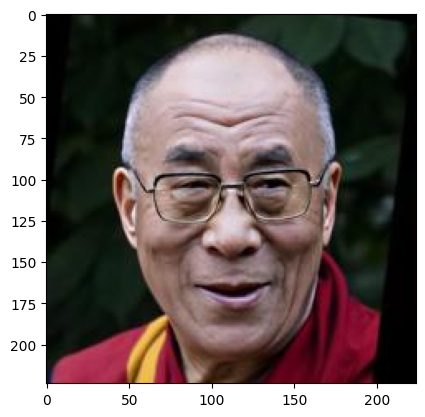

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

La función draw_box() servirá para dibujar una caja alrededor de la cara que se identifique en una imagen, se debe tener en cuenta que no todas las imagenes van a tener asociado un rostro que nuestra red pueda detectar.

In [ ]:
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

## <font color = blue > Detección de rostros con MobileNet

Para esta tarea haremos uso de MobileNet, una Red Convolucional especializada en la detección de objetos y optimizada para ejecución en dispositivos móviles, y que en este caso ha sido entrenada específicamente para la detección de rostros.

Este modelo pre-entrenado está almacenado en un formato de grafo de TensorFlow. Para realizar la lectura usaremos las funciones io.gfile y import_graph_def de TensorFlow, y el modelo será almacenado en la variable mobilenet:

In [ ]:
with tf.io.gfile.GFile('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Modelos/frozen_inference_graph_face.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

Sin embargo, el bloque de detección de rostros no nos devuelve el rostro en las mismas dimensiones que requiere Face Net, por esta razón la siguiente función se encargará de extraer la porción de la imágen que contiene el rostro y luego redimensionarla a tamaño [160x160], que es el que requiere Face

In [ ]:
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

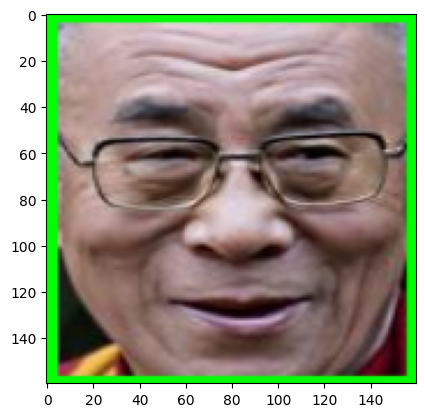

In [ ]:
faces = extract_faces(img,bboxes)
plt.imshow(faces[0])

## <font color = blue> Función para la detección de rostros

Ahora implementaremos la función encargada de realizar la detección. Esta función tendrá como entradas la imagen original y un umbral (score_threshold). Este umbral se requiere pues MobileNet detecta múltiples regiones de interés para el mismo rostro, algunas de las cuales probablemente no corresponden a un rostro. Cada una de estas regiones de interés tendrá un puntaje entre 0 y 1 que nos indicará la probabilidad de que la región pertenezca o no a un rostro: 0 indica una baja probabilidad y 1 total certeza de que la región contiene un rostro.

Así que las regiones de interés y los puntajes correspondientes serán almacenados en las variables boxes y scores respectivamente, y tomaremos las regiones de interés con un umbral mayor o igual a 0.7 (es decir con un 70% de probabilidad de que contengan un rostro). Estas regiones seleccionadas serán almacenadas en la variable bboxes que contendrá las coordenadas dentro de la imagen de la esquina superior izquierda (left, top) y de la esquina inferior derecha (right, bottom) de cada region detectada:

In [ ]:
def detect_faces(image, score_threshold=0.8):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)

    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')

    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})

    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)

    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]

    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])

    return bboxes

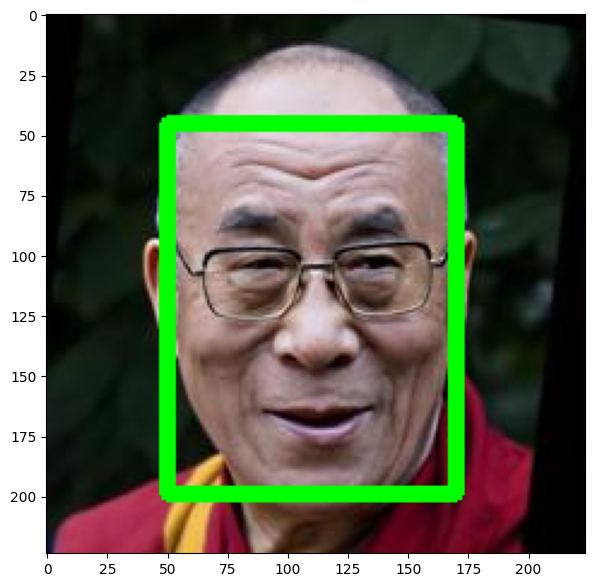

In [ ]:
bboxes = detect_faces(img)
for box in bboxes:
    detected_faces = draw_box(img,box,(0,255,0))
fig = plt.figure(figsize=(7,7))
plt.imshow(detected_faces)

## <font color=blue> Cálculo de embeddings usando Face Net

A continuación se carga el modelo el cual fue definido, creado y se le cargaron los pesos en el cuaderno ***Modelo FaceNet***.

Este modelo fue entrenado utilizando el conjunto de datos CASIA-WebFace, el cual consta de un total de 453453 imágenes sobre 10575 identidades después de la detección de rostros. El modelo con mejor rendimiento se entrenó en el conjunto de datos VGGFace2 que consta de 3.3 millones de rostros y 9000 clases.

In [3]:
face_encoder = tf.keras.models.load_model('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Modelos/Face_Encoder.h5')

Al imprimir en pantalla las variables input_shape y output_shape del modelo, podemos verificar que el tamaño de la entrada es una imagen RGB de 160x160 pixeles, mientras que a la salida se generará un embedding correspondiente a un vector de 128 elementos:

In [ ]:
print(face_encoder.input_shape)
print(face_encoder.output_shape)

(None, 160, 160, 3)
(None, 128)


Se puede observar la estructura de la red y los parámetros asociados a esta. Con respecto a la primera capa asociada a la red, recibe la imagen con 3 canales de color (RGB) que resultó de la detección de rostros con la herramienta que se mencionó previamente. Por otro lado, el embedding es un vector de tamaño 128 y es la salida del modelo.
La cantidad total de parámetros del modelo es 22.808.144, que se dividen en 22.779.312 parámetros re-entrenables, es decir que se actualizan de manera iterativa para adaptarse a los datos y al problema que se esté resolviendo y minimizando la función de pérdida. Por otro lado, se registran 28.832 parámetros no entrenables, que pueden estar asociados a hiperparámetros que están fijos desde el entrenamiento de la red.

In [4]:
face_encoder.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_2[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

La siguiente función tiene como entrada el modelo que se implementará para obtener el embedding de un rostro, y la imágen a la cual se le quiere obtener este vector. La salida será el embedding que se calculó para la imagen con el uso del modelo.

In [ ]:
def compute_embedding(model,face):
    face = face.astype('float32')

    mean, std = face.mean(), face.std()
    face = (face-mean) / std

    face = np.expand_dims(face,axis=0)

    embedding = model.predict(face)
    return embedding

In [ ]:
embedding = compute_embedding(face_encoder,faces[0])
print(embedding)

1/1 [==============================] - 2s 2s/step
[[ 2.67464697e-01  1.77259040e+00 -3.27229798e-01 -1.67616725e+00
  -6.76403418e-02 -6.48268878e-01  1.51199065e-02 -4.02786911e-01
  -1.61725426e+00 -5.26140153e-01 -4.26823229e-01  2.65140700e+00
   1.77019823e+00 -9.47749853e-01  1.17105281e+00 -2.79518783e-01
  -1.15594745e+00  1.00140762e+00  7.60913312e-01 -1.16609812e+00
  -4.63964462e-01  5.77351451e-01 -1.79484665e+00  1.78957060e-01
  -1.77988157e-01  3.86807978e-01 -2.28965926e+00  1.64308047e+00
   9.44497049e-01 -8.77157509e-01 -2.80158937e-01  3.22834849e-01
  -1.89465731e-01 -1.02031386e+00  5.89939713e-01 -1.03059816e+00
   1.19109857e+00 -2.07795292e-01  6.50579453e-01 -3.42771649e-01
   8.02075624e-01  2.12169838e+00  2.21270061e+00  5.51827192e-01
  -1.85156286e+00 -4.47659671e-01 -4.29590583e-01 -1.28035355e+00
  -4.55770493e-01  2.84464329e-01  2.74939477e-01  1.95949280e+00
   2.59841681e-01 -8.54949415e-01  7.42478430e-01  1.78146172e+00
   1.05477035e-01  3.22825

## <font color = blue> Reconocimiento Facial: Comparando los embedding

Debemos verificar que la cantidad de carpetas, que tiene asociado un individuo, es la misma para los rostros conocidos y los rostros desconocidos, esto con el fin de lograr una comparación acertada de los embedding de cada imagen.

In [ ]:
carpetas_train = os.listdir(DIR_KNOWNS)
print(len(carpetas_train))
carpetas_dev = os.listdir(DIR_UNKNOWNS)
print(len(carpetas_dev) )

500
500


Lo primero que se debe hacer es calcular el embedding de todos los rostros de referencia, es decir, los que guardaremos con anterioridad en la base de datos. Estos vectores se almacenarán en la lista known_embeddings, siempre y cuando haya una detección de rostros en las imagenes.

In [ ]:
known_faces = dict()
cont = 0
print('Procesando rostros conocidos...')
for label in carpetas_train:
    # Se crea una lista que será el valor de cada carpeta en el diccionario
    known_embeddings = []
    image_path = os.path.join(DIR_KNOWNS, label)
    cont = cont+1
    print('Procesando carpeta número '+str(cont)+'. Nombre:' + label)
    for image_name in os.listdir(os.path.join(DIR_KNOWNS, label)):
        image = load_image(image_path,image_name)
        bboxes = detect_faces(image)
        # condicional para que se guarde solo si puedo identificar la imagen
        if bboxes != []:
            face = extract_faces(image,bboxes)
            known_embeddings.append(compute_embedding(face_encoder,face[0]))
    known_faces[label] = known_embeddings

In [ ]:
# Guardar el diccionario en un archivo
#with open('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Modelos/Diccionario1.pickle', 'wb') as archivo:
#    pickle.dump(known_faces, archivo)

Es recomendable guardar los resultados de los embedding, ya que su calculo requiere una tarea computacional de tiempo. Así que se guaradan los directorios que resultaron con el calculo de los embedding de las imagenes de referencia para luego cargarlo.

In [ ]:
# Cargar el diccionario desde el archivo
with open('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Modelos/Diccionario.pickle', 'rb') as archivo:
    known_faces = pickle.load(archivo)

In [ ]:
keys_dict = known_faces.keys()
print(len(keys_dict))
print(keys_dict)

500
dict_keys(['n000397', 'n000151', 'n000193', 'n000503', 'n000167', 'n000355', 'n000399', 'n000352', 'n000194', 'n000482', 'n000476', 'n000644', 'n000220', 'n000012', 'n000449', 'n000227', 'n000015', 'n000471', 'n000485', 'n000218', 'n000211', 'n000023', 'n000447', 'n000478', 'n000216', 'n000024', 'n000440', 'n000229', 'n000289', 'n000619', 'n000084', 'n000070', 'n000242', 'n000626', 'n000048', 'n000413', 'n000621', 'n000245', 'n000077', 'n000628', 'n000273', 'n000041', 'n000425', 'n000287', 'n000079', 'n000280', 'n000610', 'n000422', 'n000274', 'n000046', 'n000025', 'n000217', 'n000441', 'n000228', 'n000446', 'n000210', 'n000022', 'n000479', 'n000484', 'n000226', 'n000014', 'n000642', 'n000219', 'n000645', 'n000477', 'n000013', 'n000221', 'n000483', 'n000448', 'n000423', 'n000611', 'n000275', 'n000281', 'n000047', 'n000629', 'n000286', 'n000272', 'n000040', 'n000616', 'n000424', 'n000049', 'n000082', 'n000412', 'n000620', 'n000618', 'n000244', 'n000288', 'n000243', 'n000071', 'n0006

Con una función análoga a la que se uso para los embedding de referencia, el siguiente paso es calcular los valores para los embedding de los rostros de prueba. La única diferencia es que los valores resultantes se van a almacenar en un nuevo directorio, definido como unknown_faces.

In [ ]:
unknown_faces = dict()
cont = 0
print('Procesando rostros desconocidos...')
for label in carpetas_dev:
    # Se crea una lista que será el valor de cada carpeta en el diccionario
    known_embeddings = []
    image_path = os.path.join(DIR_UNKNOWNS, label)
    cont = cont+1
    print('Procesando carpeta número '+str(cont)+'. Nombre:' + label)
    for image_name in os.listdir(os.path.join(DIR_UNKNOWNS, label)):
        image = load_image(image_path,image_name)
        bboxes = detect_faces(image)
        # condicional para que se guarde solo si puedo identificar la imagen
        if bboxes != []:
            face = extract_faces(image,bboxes)
            known_embeddings.append(compute_embedding(face_encoder,face[0]))
    unknown_faces[label] = known_embeddings

In [ ]:
# Guardar el diccionario en un archivo
#with open('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Modelos/desconocidos_final.pickle', 'wb') as archivo:
#    pickle.dump(unknown_faces, archivo)

In [ ]:
# Cargar el diccionario desde el archivo
with open('/content/drive/Shareddrives/Proyecto_Inteligencia_Artificial/Modelos/desconocidos_final.pickle', 'rb') as archivo:
    unknown_faces = pickle.load(archivo)

In [ ]:
len(unknown_faces)

500

Código para verificar que efectivamente se estan eligiendo carpetas(individuos) con la misma cantidad de imagenes para ambos conjuntos, de esa única manera se puede lograr un entrenamiento y una prueba de manera acertada.

In [ ]:
import os

def contar_archivos_en_carpeta(carpeta):
    contador = 0
    # Obtener la lista de archivos y carpetas en la carpeta
    contenido = os.listdir(carpeta)

    # Recorrer los elementos y contar los archivos
    for elemento in contenido:
        ruta_completa = os.path.join(carpeta, elemento)
        if os.path.isfile(ruta_completa):
            contador += 1

    return contador
cantidad_archivos=[]
# Iterar sobre los archivos
for label in carpetas_train:
    # Ruta completa del archivo
    ruta_archivo = os.path.join(DIR_KNOWNS, label)
    cantidad_archivos=contar_archivos_en_carpeta(ruta_archivo)
    print(label,cantidad_archivos,end="\n ")
cantidad_archivos=[]
# Iterar sobre los archivos
for label in carpetas_dev:
    # Ruta completa del archivo
    ruta_archivo = os.path.join(DIR_UNKNOWNS, label)
    cantidad_archivos=contar_archivos_en_carpeta(ruta_archivo)
    print(label,cantidad_archivos,end="\n ")

n000397 20
 n000151 20
 n000193 20
 n000503 20
 n000167 20
 n000355 20
 n000399 20
 n000352 20
 n000194 20
 n000482 20
 n000476 20
 n000644 20
 n000220 20
 n000012 20
 n000449 20
 n000227 20
 n000015 20
 n000471 20
 n000485 20
 n000218 20
 n000211 20
 n000023 20
 n000447 20
 n000478 20
 n000216 20
 n000024 20
 n000440 20
 n000229 20
 n000289 20
 n000619 20
 n000084 20
 n000070 20
 n000242 20
 n000626 20
 n000048 20
 n000413 20
 n000621 20
 n000245 20
 n000077 20
 n000628 20
 n000273 20
 n000041 20
 n000425 20
 n000287 20
 n000079 20
 n000280 20
 n000610 20
 n000422 20
 n000274 20
 n000046 20
 n000025 20
 n000217 20
 n000441 20
 n000228 20
 n000446 20
 n000210 20
 n000022 20
 n000479 20
 n000484 20
 n000226 20
 n000014 20
 n000642 20
 n000219 20
 n000645 20
 n000477 20
 n000013 20
 n000221 20
 n000483 20
 n000448 20
 n000423 20
 n000611 20
 n000275 20
 n000281 20
 n000047 20
 n000629 20
 n000286 20
 n000272 20
 n000040 20
 n000616 20
 n000424 20
 n000049 20
 n000082 20
 n000412 20
 n000

La función que se está definiendo, será la encargada de realizar la verificación del nuevo rostro, o rostro de prueba. Para el enfoque que se implementa con el conjunto de datos considerado, tiene como entradas dos diccionarios, el primero de los diccionarios es el resultante al calcular los embedding de referencia, así que tendra asociados algunos vectores por individuo, con un máximo de 20, si la red MobileNet fue capaz de detectar rostros en todas las imagenes, y 0 como minimo, si de la totalidad de imagenes asociadas a un rostro no hubo ninguna detección con MobileNet. Por otro lado, el segundo diccionario, tiene como claves los individuos y los embeddings de las imagenes de prueba.

La comparación será simplemente la distancia entre vectores y se les aplicara un umbral, que se fija como 11. A la salida de la función se retornará un valor indicando cuantas de las distancias son menores o iguales al umbral.

In [ ]:
def compare_faces(embs_ref, embs_desc, umbral=11):
    distancias = []
    reconocimiento = []
    for emb_desc in embs_desc:
        distancias_2 = []
        for emb_ref in embs_ref:
            distancias_2.append(np.linalg.norm(emb_ref-emb_desc))
        distancias_2 = np.array(distancias_2)

        if any(distancias_2<=umbral):
            reconocimiento.append(True)
        else:
            reconocimiento.append(False)

    return reconocimiento

Lo único que resta ahora es aplicar esta función a cada una de las imágenes de prueba. Para determinar si la imagen de prueba contiene o no el rostro de referencia será suficiente con que al menos una de las cuatro distancias calculadas (realizadas por compare_faces) sea inferior al umbral establecido anteriormente:

## <font color = blue> Eficiencia del Modelo

In [ ]:
porcentajes_cc = []
porcentajes_fp = []
for name_test in keys_dict:
    for name_train in keys_dict:
        reconocimiento = compare_faces(known_faces[name_train],unknown_faces[name_test])
        suma = sum(reconocimiento)
        if len(reconocimiento) != 0:
            porcentaje = (suma/len(reconocimiento))*100
            if name_train == name_test:
              porcentajes_cc.append(porcentaje)
            else:
              porcentajes_fp.append(porcentaje)
    #print("Cantidad de aciertos: ",suma,", Eficiencia: ",porcentaje)

In [ ]:
print(len(porcentajes_cc))
sum(porcentajes_cc)/len(porcentajes_cc)

499


95.53106212424849

In [ ]:
print(len(porcentajes_fp))
sum(porcentajes_fp)/len(porcentajes_fp)

249001


0.35817125232428737